## Import Dependencies



In [ ]:
#setting up google drive
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks')

#importing libraries that are used throughout the notebook
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
from collections import defaultdict
from IPython import display
import math
from matplotlib import pyplot as plt
import os
import pandas as pd
import random
import re
import shutil
import sys
import tarfile
import time
import requests
import zipfile
import hashlib
d2l = sys.modules[__name__]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Citations
1: my_utils.py provided as part of Lab work in ECS659U/ECS659P / ECS7026P - NEURAL NETWORKS AND DEEP LEARNING 2022/23

2: PyTorch documentation: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html?highlight=cifar 

## Structure:
1. Read the dataset and create dataloaders.
2. Create the model - Backbone and Classifier.
3. Create the loss and the optimizer.
4. Create the training function.
5. Train and evaluate the model.

## Part 1: Read Dataset and Create Dataloaders

Using PyTorch documentation, the CIFAR10 dataloader was used to load the CIFAR10 dataset.

The dataset consists of pictures with the following 10 labels:

1. plane 
2. car 
3. bird
4. cat 
5. deer 
6. dog 
7. frog 
8. horse 
9. ship
10. truck

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Batch size of 32 used to process the images
batch_size = 32

# Defining the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Extracting training batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, drop_last=True) #num_workers=2)

# Defining the testing set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Extracting testing batches
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, drop_last=True) #num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 86430454.59it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


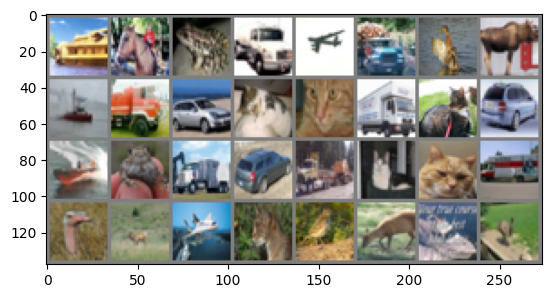

ship  horse frog  truck plane truck bird  deer  ship  truck car   cat   cat   truck cat   car   ship  frog  truck car   truck cat   cat   truck bird  deer  plane cat   bird  deer  ship  bird 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5   
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Part 2: Create the model

## The Backbone
The Backbone consists of 3 blocks. Each block has 1 Linear Layer and 2 Convolutional Layers. The input is fed in parallel into a Spatial Average Pool (SAP) and 2 convolutional layers. The output of the SAP goes into a Linear Layer and then into a ReLU activation funcion to create 'a'. The output of the 2 convolutional layers is then multiplied with the corresponding 'a' and then fed into a ReLU to give an output which is fed into the next block.


The Backbone consists of the following architecture where each block consists of:
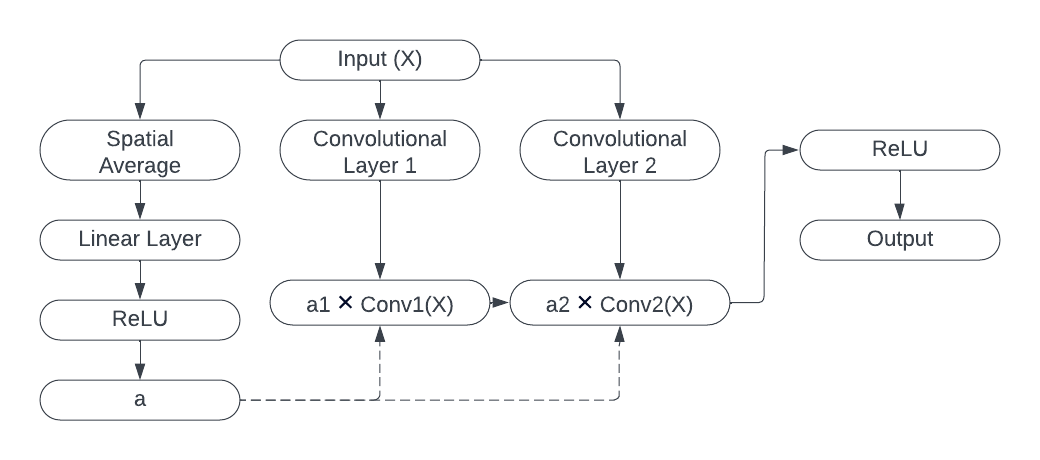

The dotted lines show that 'a' is sliced into 2 parts.

## The Classifier

When the final block produces an output, the output is fed into the following Classifier which produces a label.

The Classifer consists of the following architecture:


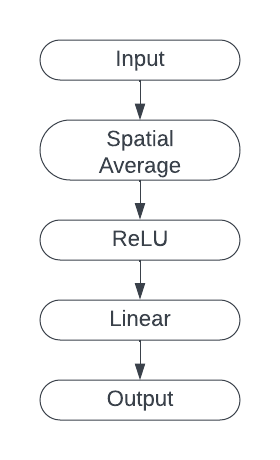

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_classes):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.num_classes = num_classes

        self.Linear1 = nn.Linear(3, 2)
        self.Avg1 = nn.AdaptiveAvgPool2d(1)
        self.Convl1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.Convl11 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)

        self.Linear2 = nn.Linear(32, 2)
        self.Avg2 = nn.AdaptiveAvgPool2d(1)
        self.Convl2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.Convl22 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)

        self.Linear3 = nn.Linear(64, 2)
        self.Avg3 = nn.AdaptiveAvgPool2d(1)
        self.Convl3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.Convl33 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.Linear = nn.Linear(128, self.num_classes)
        self.relu = nn.ReLU()
        self.Avg = nn.AdaptiveAvgPool2d(1)

        
    def forward(self, x):
        # BLOCK 1
        # In parallel, produces an average of the input and feeds the input into 2 convolutional layers.
        # Feeds the average into a linear layer.
        # Runs the output through a ReLU activation function to produce 'a'.
        # Multiplies 'a' with the output of the convolutional layers.
        # Feeds the output of the multiplication into a ReLU activation function to produce a final output.
        avg1 = self.Avg1(x)
        avg1 = avg1.view(avg1.size(0), -1)
        lin1 = self.Linear1(avg1)
        a1 = self.relu(lin1)
        conv1 = self.Convl1(x)
        conv11 = self.Convl11(x)
        out1 = (a1[:,0] * conv1 + a1[:,1] * conv11)
        out1 = self.relu(out1)

        #BLOCK 2
        # The same as Block 1 + takes the output of Block 1 as an input.
        avg2 = self.Avg2(out1)
        avg2 = avg2.view(avg2.size(0), -1)
        lin2 = self.Linear2(avg2)
        a2 = self.relu(lin2)
        conv2 = self.Convl2(out1)
        conv22 = self.Convl22(out1)
        out2 = (a2[:,0] * conv2 + a2[:,1] * conv22)
        out2 = self.relu(out2)

        #BLOCK 3
        # The same as Block 1 + takes the output of Block 2 as an input.
        avg3 = self.Avg3(out2)
        avg3 = avg3.view(avg3.size(0), -1)
        lin3 = self.Linear3(avg3)
        a3 = self.relu(lin3)
        conv3 = self.Convl3(out2)
        conv33 = self.Convl33(out2)
        out3 = (a3[:,0] * conv3 + a3[:,1] * conv33)
        out3 = self.relu(out3)

        #CLASSIFIER
        # Takes the output of Block 3 as an input.
        # Takes the average of the input.
        # Feeds the average through a ReLU activation function.
        # The output of ReLU is then fed to a linear layer which produces a final label.
        f = self.Avg(out3)
        out = self.relu(f)
        out = out.view(out.size(0), -1)
        out = self.Linear(out)
        return out

## Part 3: Create the Loss and optimiser + Part 4: Create the training function.

The loss and the optimiser are declared within the training function train_ch6.

The following scripts were taken from the my_utils.py and modified to better suit the model.

In [ ]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 8)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
class Accumulator: 
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [ ]:
def try_gpu(i=0):  
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
class Timer: 
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [ ]:
def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)        
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

In [ ]:
def use_svg_display():  
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')

In [ ]:
ones = torch.ones
zeros = torch.zeros
tensor = torch.tensor
arange = torch.arange
meshgrid = torch.meshgrid
sin = torch.sin
sinh = torch.sinh
cos = torch.cos
cosh = torch.cosh
tanh = torch.tanh
linspace = torch.linspace
exp = torch.exp
log = torch.log
normal = torch.normal
matmul = torch.matmul
int32 = torch.int32
float32 = torch.float32
concat = torch.cat
stack = torch.stack
abs = torch.abs
numpy = lambda x, *args, **kwargs: x.detach().numpy(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)
reshape = lambda x, *args, **kwargs: x.reshape(*args, **kwargs)
to = lambda x, *args, **kwargs: x.to(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
transpose = lambda x, *args, **kwargs: x.t(*args, **kwargs)

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [ ]:
# To optimise the model the weight initialisation was changed from Xavier to Kaiming.
# Learning rate was changed from 0.1 to 0.01.
# Weight decay was added and set to 0.0001.
# Momentum was added and set to 0.9.
# ReduceLROnPlateau function was added to modify the learning rate.

def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train and evaluate a model with CPU or GPU."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking type we can init different layers in different ways
            torch.nn.init.kaiming_uniform_(m.weight)
    net.apply(init_weights)
    print('training on the', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10) # added to modify learning rate
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        scheduler.step(train_loss)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [ ]:
# initialising the model
torch.manual_seed(0)
num_inputs, num_outputs, num_classes = 3, 10, 10
net = Net(num_inputs, num_outputs, num_classes)
net

Net(
  (Linear1): Linear(in_features=3, out_features=2, bias=True)
  (Avg1): AdaptiveAvgPool2d(output_size=1)
  (Convl1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convl11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear2): Linear(in_features=32, out_features=2, bias=True)
  (Avg2): AdaptiveAvgPool2d(output_size=1)
  (Convl2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convl22): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear3): Linear(in_features=64, out_features=2, bias=True)
  (Avg3): AdaptiveAvgPool2d(output_size=1)
  (Convl3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Convl33): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Linear): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (Avg): AdaptiveAvgPool2d(output_size=1)
)

## Part 5: Train and evaluate the model

loss 0.292, train acc 0.895, test acc 0.737
2737.6 examples/sec on cuda:0


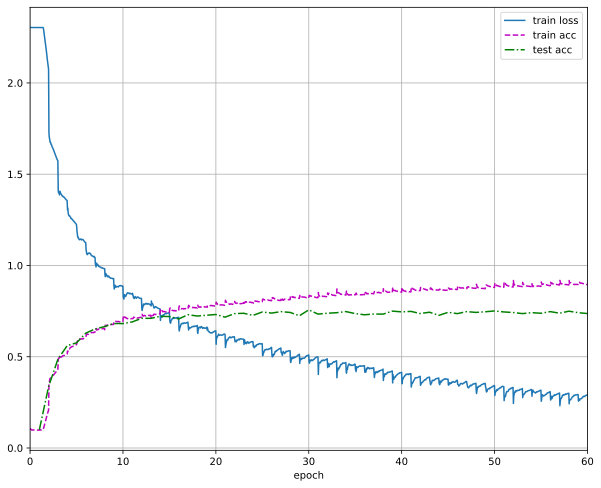

In [ ]:
num_epochs = 60 # setting the number of epochs
lr = 0.01
train_ch6(net, trainloader, testloader, num_epochs, lr) # training the model